# EEG analysis of the Focus Protocol with Deep Learning
In this notebook, I am going to analyze EEG signals collected during afternoon work sessions for days where I perfomed the Focus Protocol right before the session (Day_X_Focus_Protocol_afternoon_work_session_xyz.csv) and on days where no protocol was performed (Day_X_No_Protocol_afternoon_work_session_xyz.csv)

My hypothesis is that we will see differences between these two types of sessions, specifically on the alpha band, since this is the frequency band most robust to noise in the EEG. 

I collected my own EEG signals using the MW75 Neuro and its  Research Kit.

In this notebook I will cover:
- Loading raw EEG data
- Apliying filters
- Removing outliers
- Extracting features (in particual alpha power)
- Use a convolutional neural network to identify if there are differences between the EEG datasets

In [1]:
# Re-loading functions
%load_ext autoreload
%autoreload 2

In [2]:
# Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from glob import glob


In [3]:
# Retrieving relevant filenames
filenames = glob("../data/*.csv")
focus_protocol = "Focus_Protocol"
no_protocol = "No_Protocol"
focus_protocol_filenames = []
no_protocol_filenames = []
for filename in filenames:
    if focus_protocol in filename:
        focus_protocol_filenames.append(filename)
    elif no_protocol in filename:
        no_protocol_filenames.append(filename)


In [4]:
# Loading sample datasets
sample_file_id = 0
sample_data_after_protocol = pd.read_csv(focus_protocol_filenames[sample_file_id])
sample_data_no_protocol = pd.read_csv(no_protocol_filenames[sample_file_id])
sample_data_after_protocol

,Timestamp,EventId,Counter,Ref,DRL,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch9RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG,FeatureStatus,Checksum
0,2025-08-04T13:22:23.756Z,239,172,1727,1723,12566.10,2971.62,-5106.38,-12366.8,-12753.9,1270.78,-21542.80,-8025.79,-46581.4,-1115.45,-12240.6,-17827.50,16,7367
1,2025-08-04T13:22:23.756Z,239,186,1719,1735,12595.80,2986.64,-4760.96,-12340.4,-12703.8,1285.16,-22516.00,-8094.69,-47956.6,-1125.72,-12205.3,-19796.20,16,7659
2,2025-08-04T13:22:23.756Z,239,197,1723,1725,12561.20,2966.87,-4650.60,-12359.3,-12766.6,1283.08,-21937.10,-8082.75,-47085.6,-1104.39,-12218.7,-18716.00,16,7543
3,2025-08-04T13:22:23.757Z,239,209,1721,1723,12589.60,2979.39,-4358.84,-12322.5,-12681.4,1277.79,-22228.40,-8093.45,-47599.7,-1125.20,-12188.7,-19530.40,16,7892
4,2025-08-04T13:22:23.757Z,239,210,1719,1725,12601.60,2978.87,-4294.30,-12327.5,-12686.0,1282.68,-22584.60,-8097.39,-47988.1,-1129.20,-12189.9,-20138.60,16,7724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288979,2025-08-04T15:02:08.992Z,239,150,1771,1771,-9469.57,-6142.20,-20425.10,-11606.7,-17963.5,-5890.98,-4402.64,-8217.76,-29060.5,-6637.64,-13563.5,-4307.34,16,8137
2288980,2025-08-04T15:02:08.992Z,239,151,1771,1773,-9477.53,-6147.73,-20339.40,-11604.1,-17963.1,-5894.79,-4394.82,-8217.36,-28916.4,-6640.95,-13565.5,-4318.64,16,7580
2288981,2025-08-04T15:02:08.992Z,239,152,1765,1771,-9477.12,-6148.95,-20230.70,-11602.1,-17963.9,-5894.15,-4491.14,-8223.13,-28815.1,-6641.69,-13568.0,-4364.68,16,8205
2288982,2025-08-04T15:02:08.992Z,239,153,1769,1778,-9474.07,-6145.73,-20134.10,-11599.4,-17962.2,-5893.12,-4614.86,-8223.80,-28751.0,-6644.50,-13567.0,-4410.10,16,7357


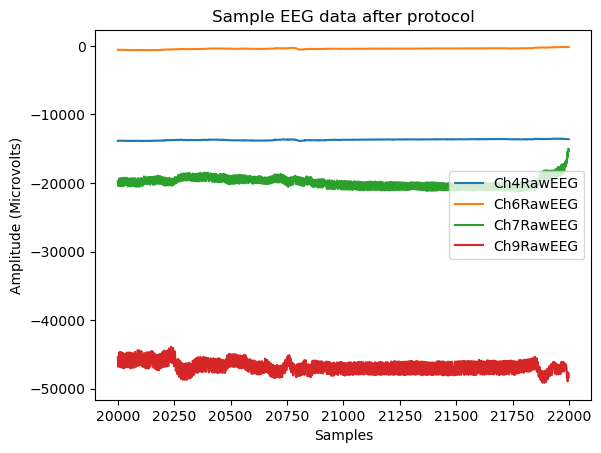

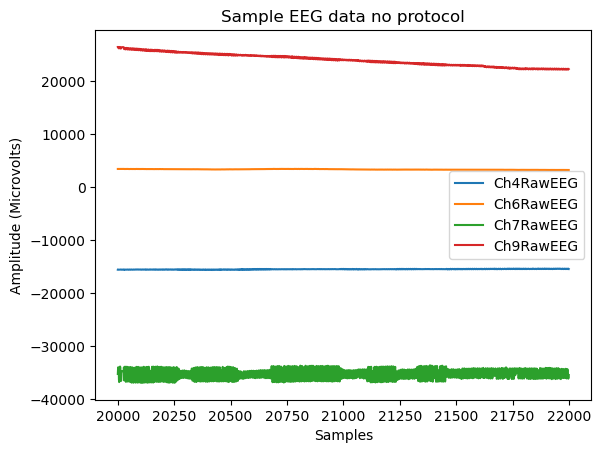

In [24]:
# Plotting sample EEG data
df_dict = {'Sample EEG data after protocol' : sample_data_after_protocol, 
           'Sample EEG data no protocol': sample_data_no_protocol}
channels_of_interest = ['Ch4RawEEG', 'Ch6RawEEG', 'Ch7RawEEG', 'Ch9RawEEG']
samples_of_interest = range(20000,22000)

for title in df_dict:
    df_dict[title][channels_of_interest].iloc[samples_of_interest].plot()
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (Microvolts)')
    plt.title(title)

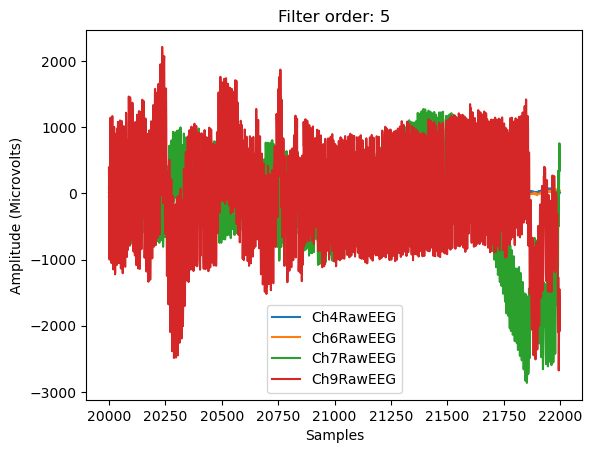

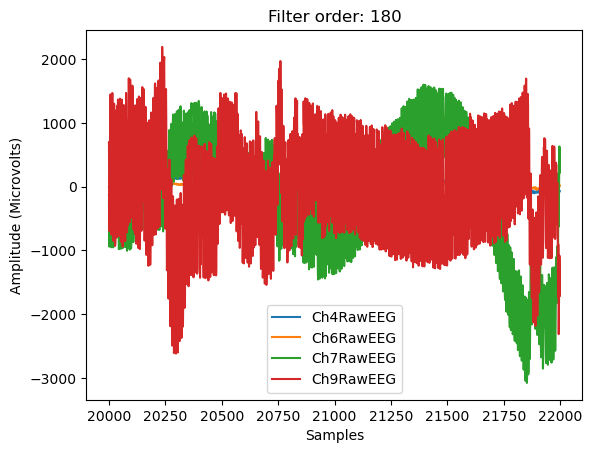

In [56]:
# Filter data

filter_order = 5
strong_filter_order = 8
fps = 500
lowcut = 7
highcut = 0.5
axis_for_df = 0 
# Scipy uses by default axis -1, which in our dfs, correspond to the number of channels
# Instead we would like to filter along axis 0, which corresponds to the samples

def butter_lowpass(cutoff, fs, order=filter_order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sos
def butter_lowpass_filter(data, cutoff, fs, order=filter_order):
    sos = butter_lowpass(cutoff, fs, order=order)
    y = signal.sosfilt(sos, data, axis=axis_for_df)
    return y
def butter_highpass(cutoff, fs, order=filter_order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    return sos
def butter_highpass_filter(data, cutoff, fs, order=filter_order):
    sos = butter_highpass(cutoff, fs, order=order)
    y = signal.sosfiltfilt(sos, data, axis=axis_for_df)
    return y

# Let's check multiple filter orders for one condition
condition = list(df_dict.keys())[0]
filtered_df_dict = dict()
orders_to_try = [5, 180]
for current_filter_order in orders_to_try:
    filtered_array = butter_highpass_filter(df_dict[condition][channels_of_interest].values, highcut, fps, order=current_filter_order)
    filtered_df_dict[current_filter_order] = pd.DataFrame(filtered_array, columns=channels_of_interest)

    filtered_df_dict[current_filter_order][channels_of_interest].iloc[samples_of_interest].plot()
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (Microvolts)')
    plt.title(f'Filter order: {current_filter_order}')


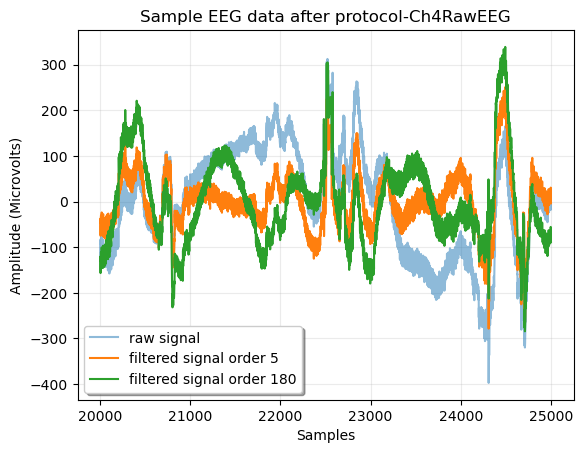

In [57]:
# Let's check for lag
x = df_dict[condition][channels_of_interest[0]].iloc[20000:25000]
baseline_correction = np.mean(x)
x_bc = x - baseline_correction
y = filtered_df_dict[orders_to_try[0]][channels_of_interest[0]].iloc[20000:25000]
y2 = filtered_df_dict[orders_to_try[1]][channels_of_interest[0]].iloc[20000:25000]
plt.plot(x_bc, alpha=0.5, label='raw signal')
plt.plot(y, label=f'filtered signal order {orders_to_try[0]}')
plt.plot(y2, label=f'filtered signal order {orders_to_try[1]}')
plt.legend(framealpha=1, shadow=True)
plt.grid(alpha=0.25)
plt.xlabel('Samples')
plt.ylabel('Amplitude (Microvolts)')
plt.title(f'{condition}-{channels_of_interest[0]}')
plt.show()

A very high filter order of 180 is not yet significantly delayed but it starts introducing distortions to the data